In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

In [2]:
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Импортируем функции из src
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items, features_generation
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [6]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [7]:
# генерируем 50 кандидатов, используя similar_items_recommendation
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [8]:
result_lvl_1.head(4)

,user_id,actual,similar_items
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105..."


In [9]:
# генерируем 50 кандидатов, используя als
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [10]:
result_lvl_1.head(4)

,user_id,actual,similar_items,als
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74..."


In [11]:
%%time
# генерируем 50 кандидатов, используя get_similar_users_recommendation
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

Wall time: 6min 29s


In [12]:
result_lvl_1.head(4)

,user_id,actual,similar_items,als,similar_users
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[9677462, 1076247, 5570974, 5570513, 1016785, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992...","[1098152, 1102250, 920528, 1062283, 1064752, 1..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853...","[944588, 905353, 1131384, 1021416, 871563, 825..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1113675, 5995953, 7442505, 6979393, 853449, 7..."


In [13]:
# генерируем 50 кандидатов, используя own_recommendations
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [14]:
result_lvl_1.head(4)

,user_id,actual,similar_items,als,similar_users,own
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[9677462, 1076247, 5570974, 5570513, 1016785, ...","[922281, 962967, 6514011, 9296837, 8090541, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992...","[1098152, 1102250, 920528, 1062283, 1064752, 1...","[976652, 988508, 5567582, 1131634, 945901, 927..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853...","[944588, 905353, 1131384, 1021416, 871563, 825...","[6391541, 936470, 939907, 9677093, 1121367, 10..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1113675, 5995953, 7442505, 6979393, 853449, 7...","[12757544, 829685, 923600, 6979393, 880530, 99..."


In [15]:
# измеряем качество на data_val_lvl_1 с помощью recall@k
methods = ['similar_items', 'als', 'similar_users', 'own']
recall = dict()
for method in methods:
    recall[method] = result_lvl_1.apply(lambda row: recall_at_k(row[method], row['actual']), axis=1).mean()

recall

{'similar_items': 0.005610131974179749,
 'als': 0.009926919460015766,
 'similar_users': 0.0007393203113854158,
 'own': 0.009511956261990253}

Как и als метод own recommendtions дают лучшие значения recall@k.

In [16]:
%%time

params = [1, 5, 10, 50, 100, 200]

for param in params:
    result_lvl_1[f'als_{param}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=param))

result_lvl_1.head(4)

Wall time: 1min 14s


,user_id,actual,similar_items,als,similar_users,own,als_1,als_5,als_10,als_50,als_100,als_200
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[9677462, 1076247, 5570974, 5570513, 1016785, ...","[922281, 962967, 6514011, 9296837, 8090541, 10...",[8090541],"[8090541, 5569374, 841584, 920200, 6533608]","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992...","[1098152, 1102250, 920528, 1062283, 1064752, 1...","[976652, 988508, 5567582, 1131634, 945901, 927...",[916122],"[916122, 1127831, 826835, 1004906, 866211]","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853...","[944588, 905353, 1131384, 1021416, 871563, 825...","[6391541, 936470, 939907, 9677093, 1121367, 10...",[1121367],"[1121367, 910032, 863885, 906524, 1037387]","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1113675, 5995953, 7442505, 6979393, 853449, 7...","[12757544, 829685, 923600, 6979393, 880530, 99...",[1084036],"[1084036, 819840, 951834, 1026118, 6979393]","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74..."


In [17]:
recall = dict()
for param in params:
    recall[f'als_{param}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'als_{param}'], row['actual']), axis=1).mean()

recall

{'als_1': 0.0029556691012702606,
 'als_5': 0.009926919460015766,
 'als_10': 0.009926919460015766,
 'als_50': 0.009926919460015766,
 'als_100': 0.009926919460015766,
 'als_200': 0.009926919460015766}

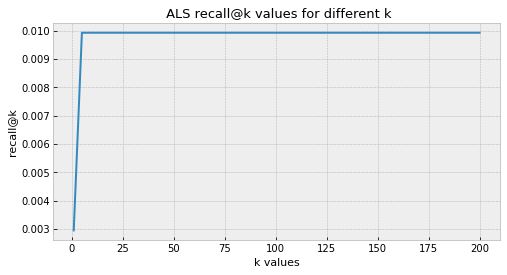

In [18]:
plt.figure(figsize=(8, 4))
with plt.style.context('bmh'):
    plt.plot(params, recall.values())
    plt.title(' ALS recall@k values for different k', fontsize=13)
    plt.xlabel('k values', fontsize=11)
    plt.ylabel('recall@k', fontsize=11)
    
plt.show()

При к>=5 значение recall@k не изменяется

In [19]:
%%time

params = [1, 20, 50, 100, 200, 500]

for param in params:
    result_lvl_1[f'own_{param}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=param))


Wall time: 42.7 s


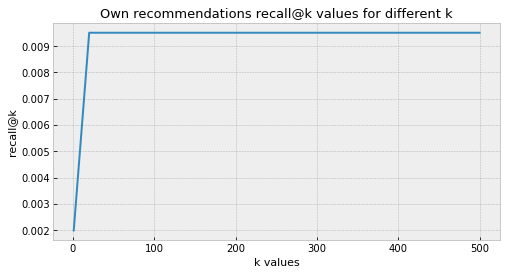

In [20]:
recall = dict()
for param in params:
    recall[f'own_{param}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'own_{param}'], row['actual']), axis=1).mean()

plt.figure(figsize=(8, 4))
with plt.style.context('bmh'):
    plt.plot(params, recall.values())
    plt.title('Own recommendations recall@k values for different k', fontsize=13)
    plt.xlabel('k values', fontsize=11)
    plt.ylabel('recall@k', fontsize=11)
    
plt.show()

При к>=5 значение recall@k не изменяется

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [21]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Генерируем кандидатов с помощью own recommendation
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [22]:
users_lvl_2.head(4)

,user_id,candidates
0,2070,"[5569230, 5569471, 1008814, 5569374, 878442, 9..."
1,2021,"[1044078, 1106523, 844179, 819255, 899624, 999..."
2,1753,"[1029743, 883202, 906883, 963686, 891134, 8956..."
3,2120,"[1106523, 8090537, 1044078, 8090521, 1029743, ..."


In [23]:
# Вытягиваем строки кандидатов в столбец
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

# Размечаем обучающую выборку на основе данных о покупках data_train_lvl_2
targets_lvl_2 = data_train_lvl_2.copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

In [24]:
targets_lvl_2['target'].value_counts()

0.0    103048
1.0      6557
Name: target, dtype: int64

In [25]:
targets_lvl_2['target'].mean()

0.0598239131426486

In [26]:
# добавляем item_features и user_features
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

data_val_lvl_2 = data_val_lvl_2.merge(item_features, on='item_id', how='left')
data_val_lvl_2 = data_val_lvl_2.merge(user_features, on='user_id', how='left')

In [27]:
# создаем и добавляем дополнительные признаки на основе агрегатных функций
data_train = data_train_lvl_2.merge(item_features, on='item_id', how='left')
data_train = data_train.merge(user_features, on='user_id', how='left')

targets_lvl_2 = features_generation(data_train, targets_lvl_2)
data_val_lvl_2 = features_generation(data_val_lvl_2, data_val_lvl_2)

In [28]:
# создаем тестовую и обучающую выборки
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

# выделяем категориальные признаки
cat_feats = cat_feats =['department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
                        'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc',
                        'household_size_desc', 'kid_category_desc']

X_train[cat_feats] = X_train[cat_feats].astype('category')
data_val_lvl_2[cat_feats] = data_val_lvl_2[cat_feats].astype('category')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101319 entries, 0 to 101318
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   user_id                 101319 non-null  int64   
 1   item_id                 101319 non-null  int64   
 2   basket_id               6557 non-null    float64 
 3   day                     6557 non-null    float64 
 4   quantity                6557 non-null    float64 
 5   sales_value             6557 non-null    float64 
 6   store_id                6557 non-null    float64 
 7   retail_disc             6557 non-null    float64 
 8   trans_time              6557 non-null    float64 
 9   week_no                 6557 non-null    float64 
 10  coupon_disc             6557 non-null    float64 
 11  coupon_match_disc       6557 non-null    float64 
 12  manufacturer            101319 non-null  int64   
 13  department              101319 non-null  category
 14  bran

In [29]:
# обучаем модель второго уровня - Light Gradient Boosting Machine
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

In [30]:
X_train['preds'] = train_preds
X_train.head(4)

,user_id,item_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_item_count_by_dep,mean_sales,week_mean_count_by_dep,mean_count_by_dep,preds
0,2070,5569230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50-74K,Unknown,Unknown,1,None/Unknown,234,14.355581,24577.666667,1755.0,0.0
1,2070,5569471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50-74K,Unknown,Unknown,1,None/Unknown,84,14.355581,24577.666667,1755.0,0.0
2,2070,1008814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50-74K,Unknown,Unknown,1,None/Unknown,15,14.355581,24577.666667,1755.0,0.0
3,2070,5569374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50-74K,Unknown,Unknown,1,None/Unknown,23,14.355581,24577.666667,1755.0,0.0


In [31]:
val_preds = lgb.predict_proba(data_val_lvl_2)


In [32]:
# реальные покупки пользователей
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

In [33]:
# предсказанные покупки пользователей, отранжированные в порядке убывания вероятности 
preds = data_val_lvl_2[['user_id', 'item_id']].copy()
preds['proba'] = val_preds[:,1]
preds = preds.groupby(['user_id', 'item_id'])['proba'].mean().reset_index()
preds = preds.groupby('user_id').apply(lambda x: x.sort_values('proba', ascending=False)['item_id'].tolist())

In [34]:
# функция дает N самых вероятных покупок пользователя, если значений не хватает добираем их из самых популярных
def get_gbm_rec(user, N=5):
    recs = preds[user][:N]
    
    top = data_val_lvl_2.groupby('item_id')['quantity'].mean().reset_index()
    top.sort_values('quantity', ascending=False, inplace=True)
    top = top['item_id'][top['item_id'] != 999999].tolist()
      
    if len(recs) < N:
        recs.extend(top[:N-len(recs)])
   
    return recs

In [35]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

#Заполняем для каждого пользователя предсказаниямя N покупок 
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

result_lvl_2['gbm'] = result_lvl_2['user_id'].apply(lambda x: get_gbm_rec(x, N=50))

In [36]:
result_lvl_2.head(4)

,user_id,actual,gbm
0,1,"[931860, 1049998, 15971874, 1002032, 1122428, ...","[821867, 834484, 1132231, 1131115, 1122428, 11..."
1,3,"[13842214, 851057, 879948, 994891, 7167218, 10...","[835476, 1053690, 9526886, 9526563, 7167249, 7..."
2,6,"[1006718, 7431990, 1108624, 1020683, 1104227, ...","[820165, 6553035, 1075214, 1078346, 1099058, 1..."
3,7,"[10255525, 994994, 1056418, 5571310, 14111027,...","[822049, 6424447, 6034857, 5592931, 5592610, 5..."


In [37]:
# считаем среднее значение точности предсказания
result_lvl_2.apply(lambda row: precision_at_k(row['gbm'], row['actual'], k=50), axis=1).mean()

0.6499510284035249

Точность двух уровневой модели намного выше точности одноуровневой.